In [21]:
from django_connect import connect
from db.models import *
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import pandas as pd
from django_pandas.io import read_frame


[2022-02-08 13:09:03-0800] INFO - prefect.FlowRunner | Beginning Flow run for 'hello-flow'
[2022-02-08 13:09:03-0800] INFO - prefect.TaskRunner | Task 'hello_task': Starting task run...
[2022-02-08 13:09:03-0800] INFO - prefect.hello_task | Hello World
[2022-02-08 13:09:03-0800] INFO - prefect.TaskRunner | Task 'hello_task': Finished task run for task with final state: 'Success'
[2022-02-08 13:09:03-0800] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


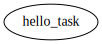

In [9]:
import prefect
from prefect import task, Flow


@task
def hello_task():
    logger = prefect.context.get("logger")
    logger.info("Hello World")
    
    
with Flow("hello-flow") as flow:
    hello_task()

flow.run()
flow.visualize()

C:\Users\yoni.browning\AppData\Roaming\Python\Python37\site-packages\distributed\node.py:182: UserWarning: Port 8782 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57140 instead
  f"Port {expected} is already in use.\n"


[2022-02-08 13:18:55-0800] INFO - prefect.FlowRunner | Beginning Flow run for 'hello-flow'
[2022-02-08 13:18:55-0800] INFO - prefect.DaskExecutor | Connecting to an existing Dask cluster at tcp://127.0.0.1:57141
[2022-02-08 13:19:00-0800] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


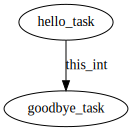

In [24]:
# In the spirit of comical overkill, implement this in dask
# Note that this will not run if we make any calls to the database
# I *Think* that this has to do with the shell setup we did before
import prefect
from prefect import task, Flow
import numpy as np
from prefect.executors import DaskExecutor
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(scheduler_port=0,
                            dashboard_address='localhost:8782')
scheduler = Client(cluster, set_as_default=False)

@task
def hello_task():
    logger = prefect.context.get("logger")
    logger.info("Hello World")
    #df = read_frame(StupidSimple.objects.all())
    #df.insert(column = 'db_entry', value= StupidSimple.objects.all(),loc = 0)
    return np.random.rand

@task
def goodbye_task(this_int):
    logger = prefect.context.get("logger")
    logger.info("Goodbye World")
    print(this_int)

with Flow("hello-flow") as flow:
    data = hello_task()
    goodbye_task(data)

executor = DaskExecutor(address=cluster.scheduler_address)    
flow.run(executor = executor)
flow.visualize()

In [6]:
StupidSimple.objects.all().delete()
SquareX.objects.all().delete()
CubeY.objects.all().delete()
SquareZ.objects.all().delete()
stupid_simple = pd.DataFrame({'x':[1,2,3,1],'y':[4,5,6,23],'z':[5.6,7.7,9.9,1.1]})
StupidSimple.objects.bulk_create([ StupidSimple(**v) for v in stupid_simple.to_dict(orient='records') ],ignore_conflicts  = True)


[<StupidSimple: StupidSimple object (1)>,
 <StupidSimple: StupidSimple object (2)>,
 <StupidSimple: StupidSimple object (3)>,
 <StupidSimple: StupidSimple object (1)>]

[2022-02-08 13:19:43-0800] INFO - prefect.FlowRunner | Beginning Flow run for 'Populate'
[2022-02-08 13:19:43-0800] INFO - prefect.TaskRunner | Task 'Extract': Starting task run...
[2022-02-08 13:19:44-0800] INFO - prefect.TaskRunner | Task 'Extract': Finished task run for task with final state: 'Success'
[2022-02-08 13:19:44-0800] INFO - prefect.TaskRunner | Task 'Compute Z': Starting task run...
[2022-02-08 13:19:45-0800] INFO - prefect.TaskRunner | Task 'Compute Z': Finished task run for task with final state: 'Success'
[2022-02-08 13:19:45-0800] INFO - prefect.TaskRunner | Task 'Compute Y': Starting task run...
[2022-02-08 13:19:45-0800] INFO - prefect.TaskRunner | Task 'Compute Y': Finished task run for task with final state: 'Success'
[2022-02-08 13:19:45-0800] INFO - prefect.TaskRunner | Task 'Compute X': Starting task run...
[2022-02-08 13:19:46-0800] INFO - prefect.TaskRunner | Task 'Compute X': Finished task run for task with final state: 'Success'
[2022-02-08 13:19:47-0800] 

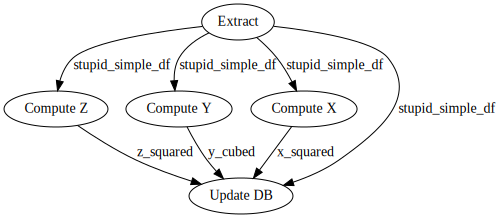

In [25]:
from prefect.triggers import all_successful, all_failed,any_successful

@task(name = "Extract")
def extract_data():
    df = read_frame(StupidSimple.objects.all())
    df.insert(column = 'db_entry', value= StupidSimple.objects.all(),loc = 0)
    return df

@task(name = "Compute X")
def transform_x(stupid_simple_df):
    return (stupid_simple_df.x**2).values

@task(name = "Compute Y")
def transform_y(stupid_simple_df):
    return (stupid_simple_df.y**3).values

@task(name = "Compute Z")
def transform_z(stupid_simple_df):
    return (stupid_simple_df.z**2).values

@task(name = "Update DB",trigger = any_successful)
def load_data(stupid_simple_df,x_squared,y_cubed,z_squared):
    x_data = pd.DataFrame({'x':stupid_simple_df.db_entry.values,'x_square':x_squared})
    SquareX.objects.bulk_create([ SquareX(**v) for v in x_data.to_dict(orient='records') ])

    y_data = pd.DataFrame({'y':stupid_simple_df.db_entry.values,'y_cube':y_cubed})
    CubeY.objects.bulk_create([ CubeY(**v) for v in y_data.to_dict(orient='records') ])

    z_data = pd.DataFrame({'z':stupid_simple_df.db_entry.values,'z_square':z_squared})
    SquareZ.objects.bulk_create([ SquareZ(**v) for v in z_data.to_dict(orient='records') ])

with Flow("Populate") as flow:
    data = extract_data()
    x2 =  transform_x(data)
    y3 =  transform_y(data)
    z2 =  transform_z(data)

    load_data(data,x2,y3,z2)
    
flow.run()
flow.visualize()